This notebook will assess the correlations between volume estimates and plant structure parameters. The following procedure will be implemented:
1. Create a unified df for volume and structure data.
2. Subset unified df into tomato, watermelon, and total dfs.
3. Create regression equations for linear, exponential, logarithmic, power, and polynomial regression.
4. Create a df for each of the regression coefficients, R2 values, and RMSE values.
5. Fit each structure and volume pair to each regression for each subset and calc stats.
6. Determine the highest R2 and lowest RMSE scoring equations for each subset's structures.
7. Create figures for each volume x structure comparing both volume calcs and regression methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

In [2]:
# Import dfs
bdf = pd.read_csv('biomass_scrape_c3.csv')
vdf = pd.read_csv('volume_directory.csv')

In [3]:
print(bdf.columns)
print(vdf.columns)

Index(['Sample ID', 'Plant ID', 'Cultivar', 'Species', 'Sampling Age',
       'Sampling Date', 'Leaf No', 'Stem No', 'Leaves Per Stem', 'Flower No',
       'Total Fruit No', 'SLA', 'Leaf Biomass', 'Shoot Biomass',
       'Flower Biomass', 'Ripe Fruit No', 'Ripe Fruit Biomass',
       'Total Fruit Biomass', 'Aboveground Biomass', 'true_ground_area',
       'L#PA', 'Unripe Fruit No', 'Unripe Fruit Biomass', 'Leaflet No',
       'Stem and Rachi No'],
      dtype='object')
Index(['sample_id', 'plot_id', 'trial_dir', 'date_dir', 'species', 'width',
       'depth', 'height', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol', 'ground_area'],
      dtype='object')


In [4]:
# Convert bdf to useful format
bdf.columns = bdf.columns.str.lower()
bdf.columns = bdf.columns.str.replace(' ', '_')
bdf.rename(columns={'aboveground_biomass':'aboveground_veg_biomass',
                    'stem_no':'shoot_no'}, inplace=True)
bdf['aboveground_total_biomass'] = bdf['aboveground_veg_biomass'] + bdf['flower_biomass'] + bdf['total_fruit_biomass']
print(bdf.columns)
bdf.drop(columns=['sampling_date', 'leaflet_no', 'stem_and_rachi_no', 'leaves_per_stem', 'sla', 
                  'ripe_fruit_no', 'ripe_fruit_biomass', 'species'], inplace=True)
print(bdf.columns)

Index(['sample_id', 'plant_id', 'cultivar', 'species', 'sampling_age',
       'sampling_date', 'leaf_no', 'shoot_no', 'leaves_per_stem', 'flower_no',
       'total_fruit_no', 'sla', 'leaf_biomass', 'shoot_biomass',
       'flower_biomass', 'ripe_fruit_no', 'ripe_fruit_biomass',
       'total_fruit_biomass', 'aboveground_veg_biomass', 'true_ground_area',
       'l#pa', 'unripe_fruit_no', 'unripe_fruit_biomass', 'leaflet_no',
       'stem_and_rachi_no', 'aboveground_total_biomass'],
      dtype='object')
Index(['sample_id', 'plant_id', 'cultivar', 'sampling_age', 'leaf_no',
       'shoot_no', 'flower_no', 'total_fruit_no', 'leaf_biomass',
       'shoot_biomass', 'flower_biomass', 'total_fruit_biomass',
       'aboveground_veg_biomass', 'true_ground_area', 'l#pa',
       'unripe_fruit_no', 'unripe_fruit_biomass', 'aboveground_total_biomass'],
      dtype='object')


In [5]:
# combine bdf and vdf by sample_id
df = pd.merge(bdf, vdf, on='sample_id', how='inner')
print(df.columns)
print(len(df))
print(df.head())

Index(['sample_id', 'plant_id', 'cultivar', 'sampling_age', 'leaf_no',
       'shoot_no', 'flower_no', 'total_fruit_no', 'leaf_biomass',
       'shoot_biomass', 'flower_biomass', 'total_fruit_biomass',
       'aboveground_veg_biomass', 'true_ground_area', 'l#pa',
       'unripe_fruit_no', 'unripe_fruit_biomass', 'aboveground_total_biomass',
       'plot_id', 'trial_dir', 'date_dir', 'species', 'width', 'depth',
       'height', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol', 'ground_area'],
      dtype='object')
24
              sample_id                         plant_id  cultivar  \
0  ta_Big_Beef_Day_Zero  Transplant-Aged Big Beef Tomato  Big Beef   
1      gp_21_07_07_2023                               21  Big Beef   
2      gp_09_06_24_2023                               09  Big Beef   
3      gp_07_08_02_2023                               07  Big Beef   
4      gp_05_09_01_2023                               05  Big Beef   

   

In [6]:
# Subset df into species dfs
tdf = df[df['species'] == 'tomato']
wdf = df[df['species'] == 'watermelon']

In [7]:
# Create regression equations
def linear(x, a, b):
    return a*x + b

def exponential(x, a, b, c):
    return a*np.exp(-b*x) + c

def power(x, a, b, c):
    return a*x**b + c

def log(x, a, b, c):
    return a*np.log(b*x + 1) + c

def poly2deg(x, a, b, c):
    return a*x**2 + b*x + c

In [8]:
# Create a df for regression evaluation
r_cols = ['subset', 'parameter', 'volume_method',
          'linear_a', 'linear_b', 'linear_r2','linear_rmse', 'linear_rrmse',
          'exponential_a', 'exponential_b', 'exponential_c', 'exponential_r2','exponential_rmse', 'exponential_rrmse',
          'power_a', 'power_b', 'power_c', 'power_r2','power_rmse', 'power_rrmse',
          'log_a', 'log_b', 'log_c', 'log_r2','log_rmse', 'log_rrmse',
          'poly2deg_a', 'poly2deg_b', 'poly2deg_c', 'poly2deg_r2','poly2deg_rmse', 'poly2deg_rrmse']
rdf = pd.DataFrame(columns=r_cols)

In [9]:
# Set combinations
b_params = ['leaf_biomass', 'shoot_biomass', 'aboveground_veg_biomass']
n_params = ['leaf_no', 'shoot_no']
v_methods = ['voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005', 'voxel_vol_002', 'voxel_vol_001', 'convh_vol']
subset_list = [[df, 'both_species'],
               [tdf, 'tomato'],
               [wdf, 'watermelon']]

In [10]:
# Define curve fit and leave one out cross validation function
def loo_opt (x, y, func):
    x.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    loo = LeaveOneOut()
    loo.get_n_splits(x)
    loo.get_n_splits(y)
    y_true = []
    y_pred = []
    popts = []
    for train_index, test_index in loo.split(x):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
        y_true.append(y_test.values[0])
        y_pred.append(func(x_test, *popt).values[0])
        popts.append(popt)
    return y_true, y_pred, popts

In [11]:
# Define row function
def regressions (param, v_method, subset):
    global rdf

    sdf = subset[0]
    subset_name = subset[1]

    # set up x and y
    xdata = sdf[v_method]
    ydata = sdf[param]

    # set up row
    row = pd.DataFrame(columns=r_cols)
    row['subset'] = [subset_name]
    row['parameter'] = [param]
    row['volume_method'] = [v_method]

    # linear
    print('Starting linear regression fit for ' + param + ' and ' + v_method + ' in ' + subset_name)
    y_true, y_pred, popts = loo_opt(xdata, ydata, linear)
    row['linear_a'] = np.mean([popt[0] for popt in popts])
    row['linear_b'] = np.mean([popt[1] for popt in popts])
    row['linear_r2'] = r2_score(y_true, y_pred)
    row['linear_rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    row['linear_rrmse'] = row['linear_rmse'] / np.mean(y_true)
    print('Conducted linear regression fit for ' + param + ' and ' + v_method + ' in ' + subset_name)

    # exponential
    y_true, y_pred, popts = loo_opt(xdata, ydata, exponential)
    row['exponential_a'] = np.mean([popt[0] for popt in popts])
    row['exponential_b'] = np.mean([popt[1] for popt in popts])
    row['exponential_c'] = np.mean([popt[2] for popt in popts])
    row['exponential_r2'] = r2_score(y_true, y_pred)
    row['exponential_rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    row['exponential_rrmse'] = row['exponential_rmse'] / np.mean(y_true)
    print('Conducted exponential regression fit for ' + param + ' and ' + v_method + ' in ' + subset_name)

    # power
    y_true, y_pred, popts = loo_opt(xdata, ydata, power)
    row['power_a'] = np.mean([popt[0] for popt in popts])
    row['power_b'] = np.mean([popt[1] for popt in popts])
    row['power_c'] = np.mean([popt[2] for popt in popts])
    row['power_r2'] = r2_score(y_true, y_pred)
    row['power_rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    row['power_rrmse'] = row['power_rmse'] / np.mean(y_true)
    print('Conducted power regression fit for ' + param + ' and ' + v_method + ' in ' + subset_name)

    # log
    y_true, y_pred, popts = loo_opt(xdata, ydata, log)
    row['log_a'] = np.mean([popt[0] for popt in popts])
    row['log_b'] = np.mean([popt[1] for popt in popts])
    row['log_c'] = np.mean([popt[2] for popt in popts])
    row['log_r2'] = r2_score(y_true, y_pred)
    row['log_rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    row['log_rrmse'] = row['log_rmse'] / np.mean(y_true)
    print('Conducted log regression fit for ' + param + ' and ' + v_method + ' in ' + subset_name)

    # poly2deg
    y_true, y_pred, popts = loo_opt(xdata, ydata, poly2deg)
    row['poly2deg_a'] = np.mean([popt[0] for popt in popts])
    row['poly2deg_b'] = np.mean([popt[1] for popt in popts])
    row['poly2deg_c'] = np.mean([popt[2] for popt in popts])
    row['poly2deg_r2'] = r2_score(y_true, y_pred)
    row['poly2deg_rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
    row['poly2deg_rrmse'] = row['poly2deg_rmse'] / np.mean(y_true)
    print('Conducted poly2deg regression fit for ' + param + ' and ' + v_method + ' in ' + subset_name)

    # append row to rdf
    rdf = pd.concat([row, rdf], ignore_index=True)

    return

In [14]:
# Run regressions
for subset in subset_list:
    for param in b_params:
        for v_method in v_methods:
            regressions(param, v_method, subset)
    print('Finished biomass regressions for ' + subset[1])
    if subset[1] != 'both_species':
        for param in n_params:
            for v_method in v_methods:
                regressions(param, v_method, subset)

Starting linear regression fit for leaf_biomass and voxel_vol_02 in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 1

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
Conducted log regression fit for leaf_biomass and voxel_vol_02 in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 1

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\3601363668.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rdf = pd.concat([row, rdf], ignore_index=True)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for leaf_biomass and convh_vol in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
Conducted log regression fit for leaf_biomass and convh_vol in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for shoot_biomass and voxel_vol_02 in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for shoot_biomass and convh_vol in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8 

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-p

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
Conducted log regression fit for shoot_biomass and convh_vol in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
Conducted log regression fit for aboveground_veg_biomass and voxel_vol_02 in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6 

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]
TRAIN: [ 0  1  2  3  4  

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
Conducted poly2deg regression fit for aboveground_veg_biomass and voxel_vol_001 in both_species
Starting linear regression fit for aboveground_veg_biomass and convh_vol in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for aboveground_veg_biomass and convh_vol in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-p

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23] TEST: [16]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
Conducted log regression fit for aboveground_veg_biomass and convh_vol in both_species
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
Conducted poly2deg regression fit for aboveground_veg_biomass and convh_vol in both_species
Finished biomass regressions for both_species
Starting linear regression fit for leaf_biomass and voxel_vol_02 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for leaf_biomass and voxel_vol_02 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for leaf_biomass and voxel_vol_01 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for leaf_biomass and voxel_vol_005 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TES

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for leaf_biomass and voxel_vol_002 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TES

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for leaf_biomass and voxel_vol_001 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TES

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted exponential regression fit for leaf_biomass and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] 

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for leaf_biomass and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for leaf_biomass and convh_vol in tomato
Starting linear regression fit for shoo

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for shoot_biomass and voxel_vol_01 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted linear regression fit for shoot_biomass and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for shoot_biomass and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted power regression fit for shoot_biomass and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8 

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for shoot_biomass and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for shoot_biomass and convh_vol in tomato
Starting linear regression fit for aboveground_veg_biomass and voxel_vol_02 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for aboveground_veg_biomass and voxel_vol_02 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for abo

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for aboveground_veg_biomass and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted power regression fit for aboveground_veg_biomass and convh_vol in tomato
TRAIN: [ 1  

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for aboveground_veg_biomass and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for aboveg

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted linear regression fit for leaf_no and voxel_vol_02 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: 

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for leaf_no and voxel_vol_02 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for leaf_no and voxel_vol_02 in tomato
Starting linear regression fit for leaf_no 

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for leaf_no and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted power regression fit for leaf_no and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for leaf_no and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
C

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80

TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for shoot_no and voxel_vol_02 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for shoot_no and voxel_vol_02 in tomato
Starting linear regression fit for shoot_

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted power regression fit for shoot_no and voxel_vol_01 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for shoot_no and voxel_vol_01 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for shoot_no and voxel_vol_01 in tomato
Starting linear regression fit for shoot_

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80

Conducted power regression fit for shoot_no and voxel_vol_005 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for shoot_no and voxel_vol_005 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for shoot_no and voxel_vol_005 in tomato
Starting linear regression fit for shoo

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for shoot_no and voxel_vol_002 in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for shoot_no and voxel_vol_002 in tomato
Starting linear regression fit for shoo

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted log regression fit for shoot_no and convh_vol in tomato
TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
Conducted poly2deg regression fit for shoot_no and convh_vol in tomato
Starting linear regression fit for leaf_biomass and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression fit for leaf_biomass and voxel_vol_02 in w

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for leaf_biomass and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for leaf_biomass and voxel_vol_02 in watermelon
Starting linear regression fit for leaf_biomass and voxel_vol_01 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for leaf_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted power regression fit for leaf_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for leaf_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for leaf_biomass and convh_vol in watermelon
Starting linear regression fit for shoot_biomass and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for shoot_biomass and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for shoot_biomass and voxel_vol_02 in watermelon
Starting linear regression fit for shoot_biomass and voxel_vol_01 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear re

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for shoot_biomass and voxel_vol_001 in watermelon
Starting linear regression fit for shoot_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression fit for shoot_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for shoot_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted power regression fit for shoot_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for shoot_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for shoot_biomass and convh_vol in watermelon
Starting linear regression fit for aboveground_veg_biomass and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression fit for aboveground_veg_biomass and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for aboveground_veg_biomass and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for aboveground_veg_biomass and voxel_vol_02 in watermelon
Starting linear regression fit for aboveground_veg_biomass and voxel_vol_01 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9]

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for aboveground_veg_biomass and voxel_vol_01 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for aboveground_veg_biomass and voxel_vol_01 in watermelon
Starting linear regression fit for aboveground_veg_biomass and voxel_vol_005 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for aboveground_veg_biomass and voxel_vol_005 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for aboveground_veg_biomass and voxel_vol_005 in watermelon
Starting linear regression fit for aboveground_veg_biomass and voxel_vol_002 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80

TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for aboveground_veg_biomass and voxel_vol_001 in watermelon
Starting linear regression fit for aboveground_veg_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression fit for aboveground_veg_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for aboveground_veg_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted power regression fit for aboveground_veg_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for aboveground_veg_biomass and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for aboveground_veg_biomass and convh_vol in watermelon
Finished biomass regressions for watermelon
Starting linear regression fit for leaf_no and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAI

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for leaf_no and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for leaf_no and voxel_vol_02 in watermelon
Starting linear regression fit for leaf_no and voxel_vol_01 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression fit for l

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for leaf_no and voxel_vol_01 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for leaf_no and voxel_vol_01 in watermelon
Starting linear regression fit for leaf_no and voxel_vol_005 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression fit for 

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80

TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression fit for leaf_no and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted exponential regression fit for leaf_no and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted power regression fit for leaf_no and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Conducted log regression fit for leaf_no and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for leaf_no and convh_vol in watermelon
Starting linear regression fit for shoot_no and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted linear regression fit for shoot_

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for shoot_no and voxel_vol_02 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for shoot_no and voxel_vol_02 in watermelon
Starting linear regression fit for shoot_no and voxel_vol_01 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80

TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for shoot_no and voxel_vol_01 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for shoot_no and voxel_vol_01 in watermelon
Starting linear regression fit for shoot_no and voxel_vol_005 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: 

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)
C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80

TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for shoot_no and voxel_vol_005 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for shoot_no and voxel_vol_005 in watermelon
Starting linear regression fit for shoot_no and voxel_vol_002 in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST

C:\Users\Steven\AppData\Local\Temp\ipykernel_9272\360830210.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, x_train, y_train, maxfev = 80000)


TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted exponential regression fit for shoot_no and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted power regression fit for shoot_no and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]

c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted log regression fit for shoot_no and convh_vol in watermelon
TRAIN: [1 2 3 4 5 6 7 8 9] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8 9] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8 9] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8 9] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8 9] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8 9] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8 9] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8 9] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7 9] TEST: [8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [9]
Conducted poly2deg regression fit for shoot_no and convh_vol in watermelon


c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Steven\anaconda3\envs\pcp_env2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
print(df)

                     sample_id                               plant_id  \
0         ta_Big_Beef_Day_Zero        Transplant-Aged Big Beef Tomato   
1             gp_21_07_07_2023                                     21   
2             gp_09_06_24_2023                                     09   
3             gp_07_08_02_2023                                     07   
4             gp_05_09_01_2023                                     05   
5   ta_German_Johnson_Day_Zero  Transplant-Aged German Johnson Tomato   
6             gp_18_07_07_2023                                     18   
7             gp_17_08_02_2023                                     17   
8             gp_19_09_01_2023                                     19   
9             gp_20_10_02_2023                                     20   
10           ta_Mambo_Day_Zero       Transplant-Aged Mambo Watermelon   
11            gp_24_07_07_2023                                     24   
12            gp_15_06_24_2023                     

In [16]:
# Get best regression equation for each parameter and volume method combination
rdf['best_r2'] = rdf[['linear_r2', 'exponential_r2', 'power_r2', 'log_r2', 'poly2deg_r2']].max(axis=1)
rdf['best_rmse'] = rdf[['linear_rmse', 'exponential_rmse', 'power_rmse', 'log_rmse', 'poly2deg_rmse']].min(axis=1)
rdf['best_rrmse'] = rdf[['linear_rrmse', 'exponential_rrmse', 'power_rrmse', 'log_rrmse', 'poly2deg_rrmse']].min(axis=1)
rdf['best_equation'] = rdf[['linear_r2', 'exponential_r2', 'power_r2', 'log_r2', 'poly2deg_r2']].idxmax(axis=1)
rdf['best_equation'] = rdf['best_equation'].str.replace('_r2', '')

In [17]:
# Sort rdf by subset, parameter, and best r2
rdf.sort_values(by=['subset', 'parameter', 'best_r2'], ascending=[True, True, False], inplace=True)

In [18]:
# Save rdf
rdf.to_csv('Biomass_and_Volume_Regressions/bv_regressions_ix3.csv', index=False)

In [12]:
rdf = pd.read_csv('Biomass_and_Volume_Regressions/bv_regressions_ix3.csv')

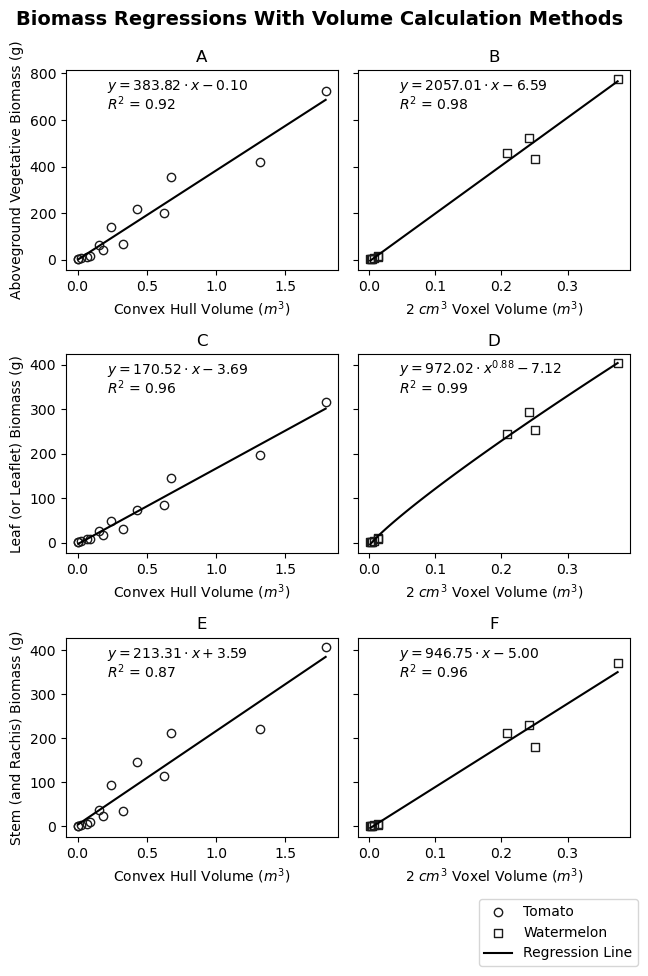

In [21]:
# Plot aboveground veg biomass on two axes, shared y axis
fig, ax = plt.subplots(3, 2, sharey='row', figsize=(6.5, 9))
fig.suptitle('Biomass Regressions With Volume Calculation Methods', fontsize=14, fontweight='bold', y=0.99)
facecolor_translucent = (0.1, 0.1, 0.1, 0.001)
edgecolor_translucent = (0.1, 0.1, 0.1, 1)
ax[0, 0].set_title('A')
ax[0, 0].scatter(tdf['convh_vol'], tdf['aboveground_veg_biomass'], label='Tomato', marker='o',
                  facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
tvx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0, 0].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'aboveground_veg_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'aboveground_veg_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Regression Line', c='black', linestyle='solid')
ax[0, 0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[0, 0].set_ylabel('Aboveground Vegetative Biomass (g)')
eq = r'$y = {a:.2f} \cdot x - {b:.2f}$'.format(a=383.82, b=0.10)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.917)
ax[0, 0].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[0, 0].transAxes)
ax[0, 0].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[0, 0].transAxes)

ax[0, 1].set_title('B')
ax[0, 1].scatter(wdf['voxel_vol_02'], wdf['aboveground_veg_biomass'], label='Watermelon', marker='s',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
wvx = np.linspace(wdf['voxel_vol_02'].min(), wdf['voxel_vol_02'].max(), 100)
ax[0, 1].plot(wvx, linear(wvx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'aboveground_veg_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['linear_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'aboveground_veg_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['linear_b']), label='Regression Line', c='black', linestyle='solid')
ax[0, 1].set_xlabel('2 $cm^3$ Voxel Volume ($m^3$)')
eq = r'$y = {a:.2f} \cdot x - {b:.2f}$'.format(a=2057.01, b=6.59)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.98)
ax[0, 1].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[0, 1].transAxes)
ax[0, 1].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[0, 1].transAxes)

ax[1, 0].set_title('C')
ax[1, 0].scatter(tdf['convh_vol'], tdf['leaf_biomass'], label='Tomato', marker='o',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
tlx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[1, 0].plot(tlx, linear(tlx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Regression Line', c='black', linestyle='solid')
ax[1, 0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[1, 0].set_ylabel('Leaf (or Leaflet) Biomass (g)')
eq = r'$y = {a:.2f} \cdot x - {b:.2f}$'.format(a=170.52, b=3.69)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.96)
ax[1, 0].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[1, 0].transAxes)
ax[1, 0].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[1, 0].transAxes)

ax[1, 1].set_title('D')
ax[1, 1].scatter(wdf['voxel_vol_02'], wdf['leaf_biomass'], label='Watermelon', marker='s',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
wlx = np.linspace(wdf['voxel_vol_02'].min(), wdf['voxel_vol_02'].max(), 100)
ax[1, 1].plot(wlx, power(wlx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['power_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['power_b'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['power_c']), label='Regression Line', c='black', linestyle='solid')
ax[1, 1].set_xlabel('2 $cm^3$ Voxel Volume ($m^3$)')
eq = r'$y = {a:.2f} \cdot x^{{{b:.2f}}} - {c:.2f}$'.format(a=972.0237, b=0.879008879, c=7.122123288)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.988)
ax[1, 1].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[1, 1].transAxes)
ax[1, 1].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[1, 1].transAxes)

ax[2, 0].set_title('E')
ax[2, 0].scatter(tdf['convh_vol'], tdf['shoot_biomass'], label='Tomato', marker='o',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
tsx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[2, 0].plot(tsx, linear(tsx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Regression Line', c='black', linestyle='solid')
ax[2, 0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[2, 0].set_ylabel('Stem (and Rachis) Biomass (g)')
eq = r'$y = {a:.2f} \cdot x + {b:.2f}$'.format(a=213.31, b=3.59)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.869)
ax[2, 0].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[2, 0].transAxes)
ax[2, 0].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[2, 0].transAxes)

ax[2, 1].set_title('F')
ax[2, 1].scatter(wdf['voxel_vol_02'], wdf['shoot_biomass'], label='Watermelon', marker='s',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
wsx = np.linspace(wdf['voxel_vol_02'].min(), wdf['voxel_vol_02'].max(), 100)
ax[2, 1].plot(wsx, linear(wsx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['linear_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['linear_b']), label='Regression Line', c='black', linestyle='solid')
ax[2, 1].set_xlabel('2 $cm^3$ Voxel Volume ($m^3$)')
eq = r'$y = {a:.2f} \cdot x - {b:.2f}$'.format(a=946.75, b=5.00)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.961)
ax[2, 1].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[2, 1].transAxes)
ax[2, 1].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[2, 1].transAxes)

# Gather unique handles and labels from all subplots
handles, labels = [], []
for row in ax:  # Loop through each row of subplots
    for ax in row:  # Loop through each subplot in the row
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            if label not in labels:  # Prevent duplicates
                handles.append(handle)
                labels.append(label)
# Sort with a custom order
custom_order = ['Tomato', 'Watermelon', 'Regression Line']
handles = [h for _, h in sorted(zip(labels, handles), key=lambda pair: custom_order.index(pair[0]))]
labels = sorted(labels, key=lambda x: custom_order.index(x))
# Create a figure-level legend with unique items
fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(1, -0.08))
# Adjust layout
fig.tight_layout()
fig.savefig('plot_figs/ix3_b.png', dpi=300, bbox_inches='tight')

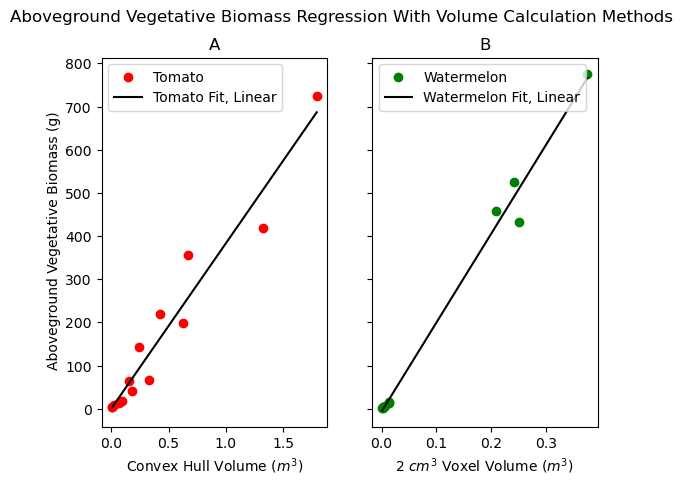

In [13]:
# Plot aboveground veg biomass on two axes, shared y axis
fig, ax = plt.subplots(1, 2, sharey=True)
fig.suptitle('Aboveground Vegetative Biomass Regression With Volume Calculation Methods')

fig.text(0.04, 0.5, 'Aboveground Vegetative Biomass (g)', va='center', rotation='vertical')

ax[0].set_title('A')
ax[0].scatter(tdf['convh_vol'], tdf['aboveground_veg_biomass'], label='Tomato', c='red')
tvx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'aboveground_veg_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'aboveground_veg_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Tomato Fit, Linear', c='black', linestyle='solid')
ax[0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[0].legend(loc='upper left')

ax[1].set_title('B')
ax[1].scatter(wdf['voxel_vol_02'], wdf['aboveground_veg_biomass'], label='Watermelon', c='green')
wvx = np.linspace(wdf['voxel_vol_02'].min(), wdf['voxel_vol_02'].max(), 100)
ax[1].plot(wvx, linear(wvx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'aboveground_veg_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['linear_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'aboveground_veg_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['linear_b']), label='Watermelon Fit, Linear', c='black', linestyle='solid')
ax[1].set_xlabel('2 $cm^3$ Voxel Volume ($m^3$)')
ax[1].legend(loc='upper left')

fig.savefig('plot_figs/ix3_abg.png', dpi=300, bbox_inches='tight')

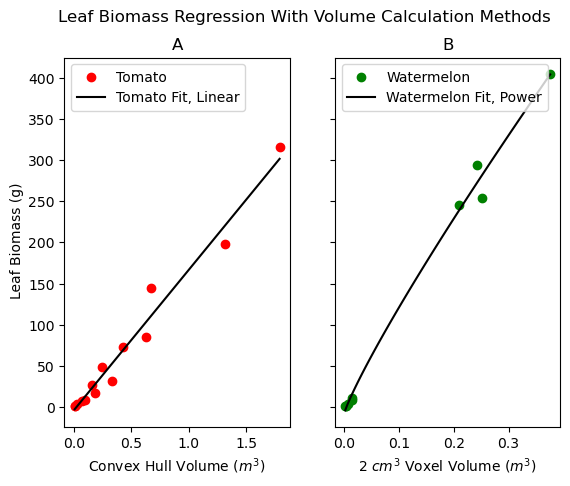

In [21]:
# Plot leaf biomass on two axes, shared y axis
fig, ax = plt.subplots(1, 2, sharey=True)
fig.suptitle('Leaf Biomass Regression With Volume Calculation Methods')

fig.text(0.04, 0.5, 'Leaf Biomass (g)', va='center', rotation='vertical')

ax[0].set_title('A')
ax[0].scatter(tdf['convh_vol'], tdf['leaf_biomass'], label='Tomato', c='red')
tlx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0].plot(tlx, linear(tlx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Tomato Fit, Linear', c='black', linestyle='solid')
ax[0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[0].legend(loc='upper left')

ax[1].set_title('B')
ax[1].scatter(wdf['voxel_vol_02'], wdf['leaf_biomass'], label='Watermelon', c='green')
wlx = np.linspace(wdf['voxel_vol_02'].min(), wdf['voxel_vol_02'].max(), 100)
ax[1].plot(wlx, power(wlx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['power_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['power_b'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['power_c']), label='Watermelon Fit, Power', c='black', linestyle='solid')
ax[1].set_xlabel('2 $cm^3$ Voxel Volume ($m^3$)')
ax[1].legend(loc='upper left')

fig.savefig('plot_figs/ix3_lb.png', dpi=300, bbox_inches='tight')


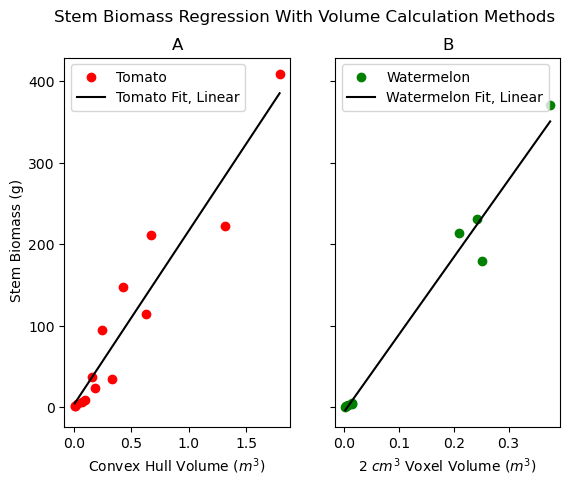

In [27]:
# Plot shoot biomass on two axes, shared y axis
fig, ax = plt.subplots(1, 2, sharey=True)
fig.suptitle('Stem Biomass Regression With Volume Calculation Methods')

fig.text(0.04, 0.5, 'Stem Biomass (g)', va='center', rotation='vertical')

ax[0].set_title('A')
ax[0].scatter(tdf['convh_vol'], tdf['shoot_biomass'], label='Tomato', c='red')
tsx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0].plot(tsx, linear(tsx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Tomato Fit, Linear', c='black', linestyle='solid')
ax[0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[0].legend(loc='upper left')

ax[1].set_title('B')
ax[1].scatter(wdf['voxel_vol_02'], wdf['shoot_biomass'], label='Watermelon', c='green')
wsx = np.linspace(wdf['voxel_vol_02'].min(), wdf['voxel_vol_02'].max(), 100)
ax[1].plot(wsx, linear(wsx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['linear_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'voxel_vol_02')]['linear_b']), label='Watermelon Fit, Linear', c='black', linestyle='solid')
ax[1].set_xlabel('2 $cm^3$ Voxel Volume ($m^3$)')
ax[1].legend(loc='upper left')

fig.savefig('plot_figs/ix3_sb.png', dpi=300, bbox_inches='tight')

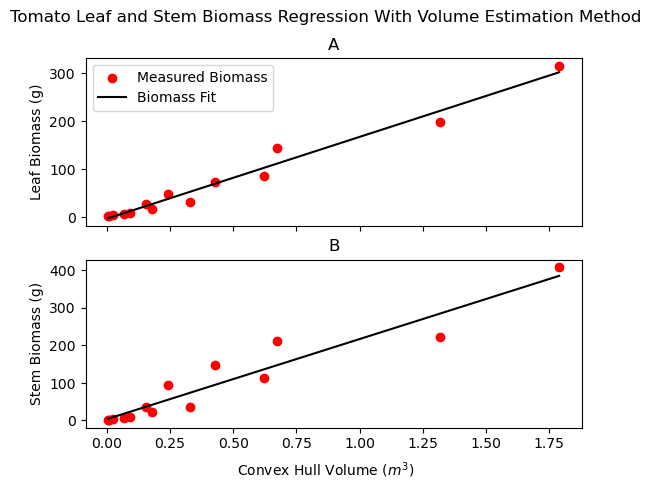

In [23]:
# Plot tomato leaf biomass and shoot biomass on two axes, shared x axis
fig, ax = plt.subplots(2, 1, sharex=True)
fig.suptitle('Tomato Leaf and Stem Biomass Regression With Volume Estimation Method')

fig.text(0.5, 0.01, 'Convex Hull Volume ($m^3$)', ha='center')

ax[0].set_title('A')
ax[0].scatter(tdf['convh_vol'], tdf['leaf_biomass'], label='Measured Biomass', c='red')
tsx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0].plot(tsx, linear(tsx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Biomass Fit', c='black', linestyle='solid')
ax[0].set_ylabel('Leaf Biomass (g)')
ax[0].legend(loc='upper left')

ax[1].set_title('B')
ax[1].scatter(tdf['convh_vol'], tdf['shoot_biomass'], label='Shoot Biomass', c='red')
tsx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[1].plot(tsx, linear(tsx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_biomass') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Shoot Biomass Fit, Linear', c='black', linestyle='solid')
ax[1].set_ylabel('Stem Biomass (g)')

fig.savefig('plot_figs/ix3_tlbsb.png', dpi=300, bbox_inches='tight')

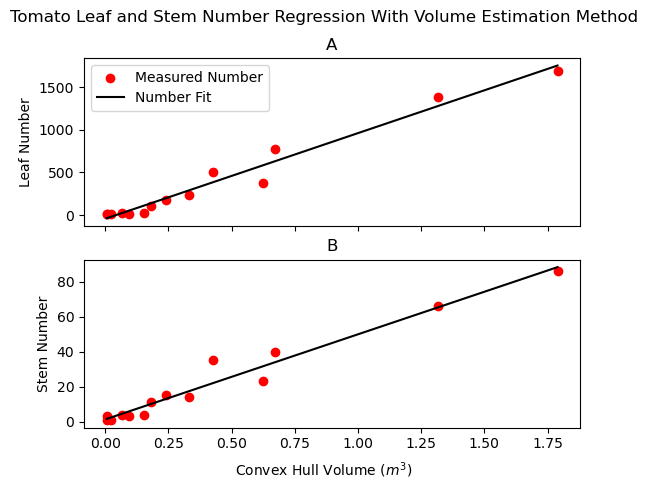

In [24]:
# Plot tomato leaf number and shoot number on two axes, shared x axis
fig, ax = plt.subplots(2, 1, sharex=True)
fig.suptitle('Tomato Leaf and Stem Number Regression With Volume Estimation Method')

fig.text(0.5, 0.01, 'Convex Hull Volume ($m^3$)', ha='center')

ax[0].set_title('A')
ax[0].scatter(tdf['convh_vol'], tdf['leaf_no'], label='Measured Number', c='red')
tsx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0].plot(tsx, linear(tsx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Number Fit', c='black', linestyle='solid')
ax[0].set_ylabel('Leaf Number')
ax[0].legend(loc='upper left')

ax[1].set_title('B')
ax[1].scatter(tdf['convh_vol'], tdf['shoot_no'], label='Shoot Number', c='red')
tsx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[1].plot(tsx, linear(tsx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Shoot Number Fit, Linear', c='black', linestyle='solid')
ax[1].set_ylabel('Stem Number')

fig.savefig('plot_figs/ix3_tlnsn.png', dpi=300, bbox_inches='tight')

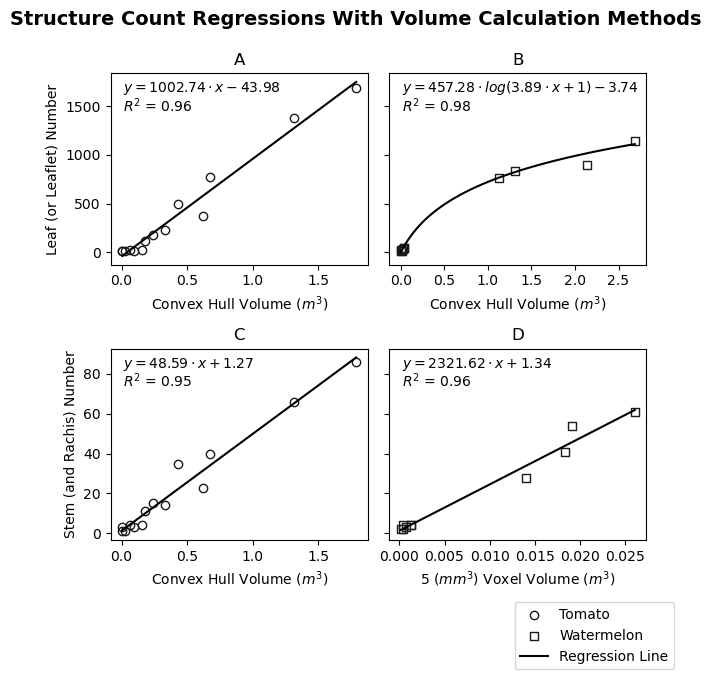

In [29]:
# Plot aboveground veg biomass on two axes, shared y axis
fig, ax = plt.subplots(2, 2, sharey='row', figsize=(6.5, 6))
fig.suptitle('Structure Count Regressions With Volume Calculation Methods', fontsize=14, fontweight='bold', y=0.99)
facecolor_translucent = (0.1, 0.1, 0.1, 0.001)
edgecolor_translucent = (0.1, 0.1, 0.1, 1)

ax[0, 0].set_title('A')
ax[0, 0].scatter(tdf['convh_vol'], tdf['leaf_no'], label='Tomato', marker='o',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
tlnx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0, 0].plot(tlnx, linear(tlnx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Regression Line', c='black', linestyle='solid')
ax[0, 0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[0, 0].set_ylabel('Leaf (or Leaflet) Number')
eq = r'$y = {a:.2f} \cdot x - {b:.2f}$'.format(a=1002.74, b=43.98)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.96)
ax[0, 0].text(0.05, 0.9, eq, ha='left', va='baseline', transform=ax[0, 0].transAxes)
ax[0, 0].text(0.05, 0.8, r2, ha='left', va='baseline', transform=ax[0, 0].transAxes)

ax[0, 1].set_title('B')
ax[0, 1].scatter(wdf['convh_vol'], wdf['leaf_no'], label='Watermelon', marker='s',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
wlnx = np.linspace(wdf['convh_vol'].min(), wdf['convh_vol'].max(), 100)
ax[0, 1].plot(wlnx, log(wlnx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['log_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['log_b'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['log_c']), label='Regression Line', c='black', linestyle='solid')
ax[0, 1].set_xlabel('Convex Hull Volume ($m^3$)')
eq = r'$y = {a:.2f} \cdot log({b:.2f} \cdot x + 1) - {c:.2f}$'.format(a=457.28, b=3.89, c=3.74)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.98)
ax[0, 1].text(0.05, 0.9, eq, ha='left', va='baseline', transform=ax[0, 1].transAxes)
ax[0, 1].text(0.05, 0.8, r2, ha='left', va='baseline', transform=ax[0, 1].transAxes)

ax[1, 0].set_title('C')
ax[1, 0].scatter(tdf['convh_vol'], tdf['shoot_no'], label='Tomato', marker='o',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
tnsx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[1, 0].plot(tnsx, linear(tnsx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Regression Line', c='black', linestyle='solid')
ax[1, 0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[1, 0].set_ylabel('Stem (and Rachis) Number')
eq = r'$y = {a:.2f} \cdot x + {b:.2f}$'.format(a=48.59, b=1.27)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.95)
ax[1, 0].text(0.05, 0.9, eq, ha='left', va='baseline', transform=ax[1, 0].transAxes)
ax[1, 0].text(0.05, 0.8, r2, ha='left', va='baseline', transform=ax[1, 0].transAxes)

ax[1, 1].set_title('D')
ax[1, 1].scatter(wdf['voxel_vol_005'], wdf['shoot_no'], label='Watermelon', marker='s',
																		facecolors=facecolor_translucent, edgecolors=edgecolor_translucent)
wsnx = np.linspace(wdf['voxel_vol_005'].min(), wdf['voxel_vol_005'].max(), 100)
ax[1, 1].plot(wsnx, linear(wsnx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'voxel_vol_005')]['linear_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'voxel_vol_005')]['linear_b']), label='Regression Line', c='black', linestyle='solid')
ax[1, 1].set_xlabel('5 ($mm^3$) Voxel Volume ($m^3$)')
eq = r'$y = {a:.2f} \cdot x + {b:.2f}$'.format(a=2321.62, b=1.34)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.96)
ax[1, 1].text(0.05, 0.9, eq, ha='left', va='baseline', transform=ax[1, 1].transAxes)
ax[1, 1].text(0.05, 0.8, r2, ha='left', va='baseline', transform=ax[1, 1].transAxes)

# Gather unique handles and labels from all subplots
handles, labels = [], []
for row in ax:  # Loop through each row of subplots
    for ax in row:  # Loop through each subplot in the row
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            if label not in labels:  # Prevent duplicates
                handles.append(handle)
                labels.append(label)
# Sort with a custom order
custom_order = ['Tomato', 'Watermelon', 'Regression Line']
handles = [h for _, h in sorted(zip(labels, handles), key=lambda pair: custom_order.index(pair[0]))]
labels = sorted(labels, key=lambda x: custom_order.index(x))
# Create a figure-level legend with unique items
fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(1, -0.12))
# Adjust layout
fig.tight_layout()
fig.savefig('plot_figs/ix3_n.png', dpi=300, bbox_inches='tight')

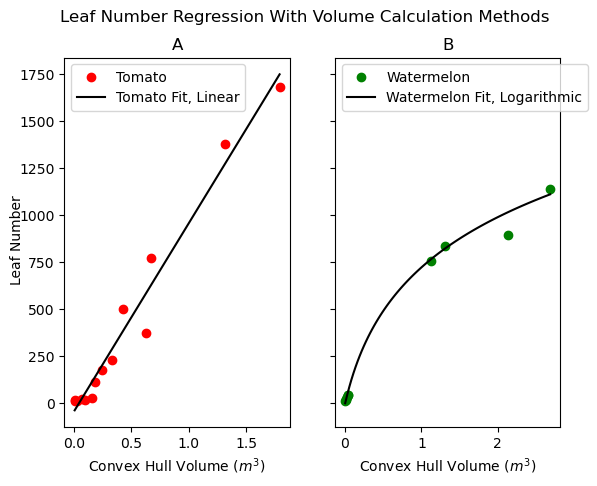

In [25]:
# Plot leaf number on two axes, shared y axis
fig, ax = plt.subplots(1, 2, sharey=True)
fig.suptitle('Leaf Number Regression With Volume Calculation Methods')

fig.text(0.04, 0.5, 'Leaf Number', va='center', rotation='vertical')

ax[0].set_title('A')
ax[0].scatter(tdf['convh_vol'], tdf['leaf_no'], label='Tomato', c='red')
tlnx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0].plot(tlnx, linear(tlnx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Tomato Fit, Linear', c='black', linestyle='solid')
ax[0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[0].legend(loc='upper left')

ax[1].set_title('B')
ax[1].scatter(wdf['convh_vol'], wdf['leaf_no'], label='Watermelon', c='green')
wlnx = np.linspace(wdf['convh_vol'].min(), wdf['convh_vol'].max(), 100)
ax[1].plot(wlnx, log(wlnx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['log_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['log_b'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_no') & (rdf['volume_method'] == 'convh_vol')]['log_c']), label='Watermelon Fit, Logarithmic', c='black', linestyle='solid')
ax[1].set_xlabel('Convex Hull Volume ($m^3$)')
ax[1].legend(loc='upper left')

plt.savefig('plot_figs/ix3_ln.png', dpi=300, bbox_inches='tight')

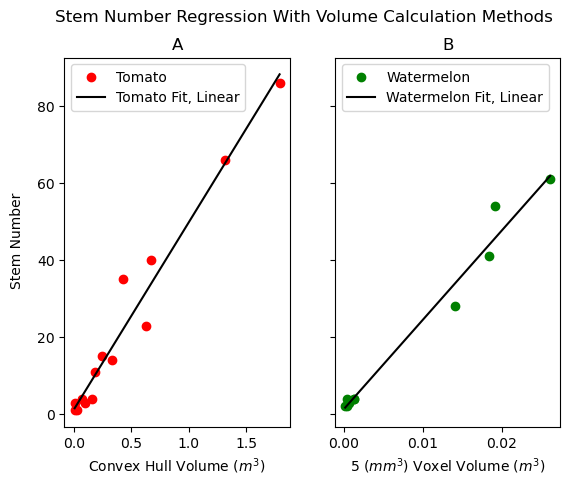

In [26]:
# Plot shoot number on two axes, shared y axis
fig, ax = plt.subplots(1, 2, sharey=True)
fig.suptitle('Stem Number Regression With Volume Calculation Methods')

fig.text(0.04, 0.5, 'Stem Number', va='center', rotation='vertical')


ax[0].set_title('A')
ax[0].scatter(tdf['convh_vol'], tdf['shoot_no'], label='Tomato', c='red')
tnsx = np.linspace(tdf['convh_vol'].min(), tdf['convh_vol'].max(), 100)
ax[0].plot(tnsx, linear(tnsx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'convh_vol')]['linear_a'], *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'convh_vol')]['linear_b']), label='Tomato Fit, Linear', c='black', linestyle='solid')
ax[0].set_xlabel('Convex Hull Volume ($m^3$)')
ax[0].legend(loc='upper left')

ax[1].set_title('B')
ax[1].scatter(wdf['voxel_vol_005'], wdf['shoot_no'], label='Watermelon', c='green')
wsnx = np.linspace(wdf['voxel_vol_005'].min(), wdf['voxel_vol_005'].max(), 100)
ax[1].plot(wsnx, linear(wsnx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'voxel_vol_005')]['linear_a'], *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_no') & (rdf['volume_method'] == 'voxel_vol_005')]['linear_b']), label='Watermelon Fit, Linear', c='black', linestyle='solid')
ax[1].set_xlabel('5 ($mm^3$) Voxel Volume ($m^3$)')
ax[1].legend(loc='upper left')

fig.savefig('plot_figs/ix3_sn.png', dpi=300, bbox_inches='tight')